# Customer Churn Analytics - Home Assignment
**Check Point - Senior Data Analyst**

---

## Part 1 — Data Preparation

### 1.1 Load Libraries & Data

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Load datasets
charges = pd.read_csv('./data/charges_data.csv')
personal = pd.read_csv('./data/personal_data.csv')
plan = pd.read_csv('./data/plan_data.csv')

print(f'Charges:  {charges.shape[0]:,} rows, {charges.shape[1]} columns')
print(f'Personal: {personal.shape[0]:,} rows, {personal.shape[1]} columns')
print(f'Plan:     {plan.shape[0]:,} rows, {plan.shape[1]} columns')

Charges:  7,032 rows, 8 columns
Personal: 5,283 rows, 5 columns
Plan:     3,540 rows, 10 columns


### 1.2 Initial Exploration

In [27]:
print('=== Charges Data ===')
print(charges.dtypes)
print(f'\nMissing values:\n{charges.isnull().sum()}')
print(f'\nChurn distribution:\n{charges.churn.value_counts()}')
print(f'\nOverall churn rate: {charges.churn.eq("Yes").mean():.1%}')

=== Charges Data ===
customerID           object
tenure                int64
contract             object
paperlessBilling     object
paymentMethod        object
monthlyCharges      float64
totalCharges        float64
churn                object
dtype: object

Missing values:
customerID            0
tenure                0
contract              0
paperlessBilling      0
paymentMethod         0
monthlyCharges      455
totalCharges        455
churn                 0
dtype: int64

Churn distribution:
churn
No     5163
Yes    1869
Name: count, dtype: int64

Overall churn rate: 26.6%


In [28]:
print('=== Personal Data ===')
print(personal.dtypes)
print(f'\nMissing values:\n{personal.isnull().sum()}')
print(f'\nUnique values:')
print(f'  gender:     {personal.gender.unique()}')
print(f'  partner:    {personal.partner.unique()}')
print(f'  dependents: {personal.dependents.unique()}')
print(f'  age range:  {personal.age.min()} - {personal.age.max()}')

=== Personal Data ===
customerID    object
gender        object
partner       object
dependents    object
age            int64
dtype: object

Missing values:
customerID    0
gender        0
partner       0
dependents    0
age           0
dtype: int64

Unique values:
  gender:     ['Male' 'Female']
  partner:    ['No' 'Yes']
  dependents: ['No' 'Yes']
  age range:  20 - 90


In [29]:
print('=== Plan Data ===')
print(plan.dtypes)
print(f'\nMissing values:\n{plan.isnull().sum()}')
print(f'\nInternet service types: {plan.internetService.unique()}')

=== Plan Data ===
customerID          object
phoneService        object
multipleLines       object
internetService     object
onlineSecurity      object
onlineBackup        object
deviceProtection    object
techSupport         object
streamingTV         object
streamingMovies     object
dtype: object

Missing values:
customerID          0
phoneService        0
multipleLines       0
internetService     0
onlineSecurity      0
onlineBackup        0
deviceProtection    0
techSupport         0
streamingTV         0
streamingMovies     0
dtype: int64

Internet service types: ['DSL' 'Fiber optic' 'No']


### 1.3 Data Coverage & Join Validation

The three datasets have different row counts. Before joining, we check the overlap between them 
and verify that the churn rate is consistent across subsets (i.e., no systematic bias from missing data).

In [30]:
# Check overlap between datasets
c_ids = set(charges.customerID)
p_ids = set(personal.customerID)
pl_ids = set(plan.customerID)

print('Customer ID overlap:')
print(f'  Charges ∩ Personal: {len(c_ids & p_ids):,}')
print(f'  Charges ∩ Plan:     {len(c_ids & pl_ids):,}')
print(f'  Personal ∩ Plan:    {len(p_ids & pl_ids):,}')
print(f'  All three:          {len(c_ids & p_ids & pl_ids):,}')

Customer ID overlap:
  Charges ∩ Personal: 5,276
  Charges ∩ Plan:     3,537
  Personal ∩ Plan:    3,540
  All three:          3,537


In [31]:
# Validate churn rate consistency across data subsets
df_full = charges.merge(personal, on='customerID', how='left', indicator='_personal') \
                  .merge(plan, on='customerID', how='left', indicator='_plan')

df_full['has_personal'] = df_full['_personal'] == 'both'
df_full['has_plan'] = df_full['_plan'] == 'both'

subsets = {
    'All charges': df_full,
    'Has personal': df_full[df_full.has_personal],
    'Has plan': df_full[df_full.has_plan],
    'Has all data': df_full[df_full.has_personal & df_full.has_plan]
}

coverage = pd.DataFrame({
    'Customers': {k: len(v) for k, v in subsets.items()},
    'Churned': {k: v.churn.eq('Yes').sum() for k, v in subsets.items()},
    'Churn Rate': {k: f"{v.churn.eq('Yes').mean():.1%}" for k, v in subsets.items()}
})

coverage

,Customers,Churned,Churn Rate
All charges,7032,1869,26.6%
Has personal,5276,1383,26.2%
Has plan,3537,921,26.0%
Has all data,3537,921,26.0%


**Conclusion:** Churn rate is consistent (~26%) across all subsets. No systematic bias from missing personal/plan data. 
LEFT JOIN from `charges_data` as the base table is valid.

**Additional finding:** Every customer with plan data also has personal data (plan ≈ all data), 
indicating that plan data is a subset of personal data in this dataset.

### 1.4 Create Unified Dataset

In [32]:
# Create final unified dataset using LEFT JOIN from charges
df = charges.merge(personal, on='customerID', how='left') \
            .merge(plan, on='customerID', how='left')

print(f'Unified dataset: {df.shape[0]:,} rows, {df.shape[1]} columns')
print(f'\nMissing values summary:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Unified dataset: 7,032 rows, 21 columns

Missing values summary:
monthlyCharges       455
totalCharges         455
gender              1756
partner             1756
dependents          1756
age                 1756
phoneService        3495
multipleLines       3495
internetService     3495
onlineSecurity      3495
onlineBackup        3495
deviceProtection    3495
techSupport         3495
streamingTV         3495
streamingMovies     3495
dtype: int64


### 1.5 Missing Charges Investigation

In [33]:
# Investigate 455 missing charge values
missing_charges = df[df.monthlyCharges.isna()]

print(f'Rows with missing charges: {len(missing_charges)}')
print(f'\nChurn rate (missing charges): {missing_charges.churn.eq("Yes").mean():.1%}')
print(f'Churn rate (overall):          {df.churn.eq("Yes").mean():.1%}')
print(f'\nContract distribution (missing charges):')
print(missing_charges.contract.value_counts())
print(f'\nTenure stats (missing charges):')
print(missing_charges.tenure.describe())

Rows with missing charges: 455

Churn rate (missing charges): 25.5%
Churn rate (overall):          26.6%

Contract distribution (missing charges):
contract
Month-to-month    246
One year          106
Two year          103
Name: count, dtype: int64

Tenure stats (missing charges):
count    455.000000
mean      33.395604
std       24.566497
min        1.000000
25%       10.000000
50%       32.000000
75%       56.000000
max       72.000000
Name: tenure, dtype: float64


**Conclusion:** 455 customers have missing `monthlyCharges` and `totalCharges`. 
Their churn rate (~25.5%) is similar to the overall rate (~26.6%), and their tenure/contract distributions are comparable. 
This appears to be a data collection issue, not systematic.

**Decision:** These rows are included in all analyses except charge-based ones, where they will be filtered out.

## Part 2 — Analysis

### 2.1 Churn by Tenure Groups

Customers are grouped into four tenure ranges based on **quartile boundaries** (Q1=9, Q2=29, Q3=55).
This approach ensures roughly equal group sizes while creating meaningful business segments:
new customers (0–9 months), establishing (10–29), loyal (30–55), and long-term (56+).

In [34]:
# Define tenure groups based on quartile boundaries
bins = [0, 9, 29, 55, 72]
labels = ['0-9', '10-29', '30-55', '56-72']

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

tenure_analysis = df.groupby('tenure_group', observed=True)['churn'].agg(
    total='count',
    churned=lambda x: (x == 'Yes').sum()
)
tenure_analysis['churn_rate'] = (tenure_analysis['churned'] / tenure_analysis['total'] * 100).round(1)

print('Churn Rate by Tenure Group:')
print('=' * 45)
print(tenure_analysis)
print(f'\nHighest churn: {tenure_analysis.churn_rate.idxmax()} months ({tenure_analysis.churn_rate.max()}%)')

Churn Rate by Tenure Group:
              total  churned  churn_rate
tenure_group                            
0-9            1843      923        50.1
10-29          1715      486        28.3
30-55          1719      324        18.8
56-72          1755      136         7.7

Highest churn: 0-9 months (50.1%)


In [35]:
contingency = pd.crosstab(df['tenure_group'], df['churn'])
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f'Tenure Group vs Churn:')
print(f'  Chi² = {chi2:,.1f}  |  p-value = {p_value:.2e}  |  df = {dof}')

Tenure Group vs Churn:
  Chi² = 895.9  |  p-value = 6.84e-194  |  df = 3


**Conclusion:** Both new (0-9 months) and establishing (10-29 months) customers 
show above-average churn rates, with new customers being the most critical group 
at approximately 50%. Churn drops significantly with tenure — long-term customers 
(56+ months) show only approximately 8% churn. This suggests that the first 
two years are a critical retention window, with the highest risk concentrated 
in the first 9 months.

### 2.2 Selecting an Additional Churn Dimension

To identify the most impactful additional dimension, we scan churn rates across all categorical variables
and measure the **spread** (difference between highest and lowest churn rate within each variable).

In [36]:
# Quick scan: churn rate by each categorical variable
categorical_cols = ['contract', 'paymentMethod', 'paperlessBilling', 
                    'internetService', 'onlineSecurity', 'onlineBackup',
                    'techSupport', 'deviceProtection', 'phoneService',
                    'multipleLines', 'streamingTV', 'streamingMovies',
                    'gender', 'partner', 'dependents']

for col in categorical_cols:
    temp = df.dropna(subset=[col])
    group = temp.groupby(col)['churn'].apply(lambda x: (x == 'Yes').mean() * 100).round(1)
    spread = group.max() - group.min()
    print(f'\n--- {col} (spread: {spread:.1f}pp) ---')
    print(group.sort_values(ascending=False).to_string())


--- contract (spread: 39.9pp) ---
contract
Month-to-month    42.7
One year          11.3
Two year           2.8

--- paymentMethod (spread: 30.0pp) ---
paymentMethod
Electronic check             45.3
Mailed check                 19.2
Bank transfer (automatic)    16.7
Credit card (automatic)      15.3

--- paperlessBilling (spread: 17.2pp) ---
paperlessBilling
Yes    33.6
No     16.4

--- internetService (spread: 33.6pp) ---
internetService
Fiber optic    40.8
DSL            18.6
No              7.2

--- onlineSecurity (spread: 34.3pp) ---
onlineSecurity
No                     41.5
Yes                    13.8
No internet service     7.2

--- onlineBackup (spread: 32.4pp) ---
onlineBackup
No                     39.6
Yes                    21.0
No internet service     7.2

--- techSupport (spread: 33.7pp) ---
techSupport
No                     40.9
Yes                    14.4
No internet service     7.2

--- deviceProtection (spread: 31.4pp) ---
deviceProtection
No                     38

In [37]:
test_cols = ['contract', 'paymentMethod', 'onlineSecurity', 'techSupport', 'internetService']

print('Chi-Square Test: Churn vs Categorical Variables')
print('=' * 55)

for col in test_cols:
    temp = df.dropna(subset=[col])
    contingency = pd.crosstab(temp[col], temp['churn'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    print(f'\n{col}:')
    print(f'  Chi² = {chi2:,.1f}  |  p-value = {p_value:.2e}  |  df = {dof}')

Chi-Square Test: Churn vs Categorical Variables

contract:
  Chi² = 1,179.5  |  p-value = 7.33e-257  |  df = 2

paymentMethod:
  Chi² = 645.4  |  p-value = 1.43e-139  |  df = 3

onlineSecurity:
  Chi² = 437.6  |  p-value = 9.34e-96  |  df = 2

techSupport:
  Chi² = 414.7  |  p-value = 9.05e-91  |  df = 2

internetService:
  Chi² = 352.4  |  p-value = 3.03e-77  |  df = 2


### 2.3 Deep Dive: Churn by Contract Type

**Why contract?** It has the largest spread (39.9 percentage points) among all categorical variables,
and the business logic is clear: customers without long-term commitment can leave at any time,
while contracted customers face a switching barrier.

In [38]:
# Detailed churn analysis by contract type
contract_analysis = df.groupby('contract')['churn'].agg(
    total='count',
    churned=lambda x: (x == 'Yes').sum()
)
contract_analysis['churn_rate'] = (contract_analysis['churned'] / contract_analysis['total'] * 100).round(1)

print('Churn Rate by Contract Type:')
print('=' * 50)
print(contract_analysis.sort_values('churn_rate', ascending=False))
print(f'\nMonth-to-month customers represent {len(df[df.contract=="Month-to-month"]):,} out of {len(df):,} '
      f'({len(df[df.contract=="Month-to-month"])/len(df)*100:.1f}%) of all customers')

Churn Rate by Contract Type:
                total  churned  churn_rate
contract                                  
Month-to-month   3875     1655        42.7
One year         1472      166        11.3
Two year         1685       48         2.8

Month-to-month customers represent 3,875 out of 7,032 (55.1%) of all customers


**Conclusion:** Month-to-month customers have a dramatically higher churn rate (43%) compared to
One-year (11%) and Two-year (3%) contracts. Importantly, Month-to-month is also the **largest segment**,
meaning this is where the biggest retention opportunity lies.

However, converting all Month-to-month customers to long-term contracts is not realistic.
A more practical approach would be to identify sub-segments within Month-to-month
(e.g., by tenure, charges, or services used) to target the most convertible customers
with tailored retention offers. This is explored further in the slides under Next Questions.

## Part 3 — Visualization

### 3.1 Churn Rate by Tenure Group

This chart shows a clear downward trend — churn rate decreases as tenure increases,
highlighting the first 9 months as the critical retention window.

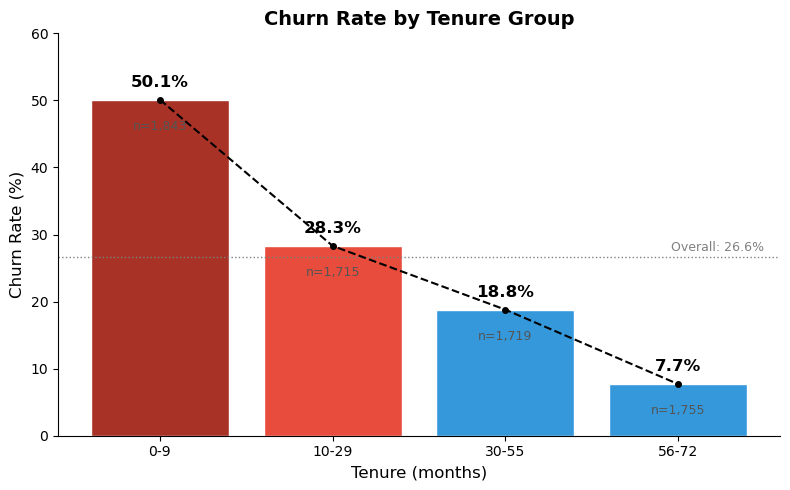

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

overall_churn = df['churn'].eq('Yes').mean() * 100

# Colors: red for above average, blue for below
colors = ['#e74c3c' if x > overall_churn else '#3498db' 
          for x in tenure_analysis['churn_rate']]
# Darken the highest
colors[0] = '#a93226'

bars = ax.bar(tenure_analysis.index, tenure_analysis['churn_rate'], color=colors, edgecolor='white')

# Add percentage labels on bars and n= below
for bar, rate, total in zip(bars, tenure_analysis['churn_rate'], tenure_analysis['total']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{rate}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 3,
            f'n={total:,}', ha='center', va='top', fontsize=9, color='#555555')

# Trend line
ax.plot(range(len(tenure_analysis)), tenure_analysis['churn_rate'], 
        color='black', linestyle='--', linewidth=1.5, marker='o', markersize=4, zorder=5)

# Overall churn rate reference line
ax.axhline(y=overall_churn, color='gray', linestyle=':', linewidth=1)
ax.text(3.5, overall_churn + 1, f'Overall: {overall_churn:.1f}%', 
        ha='right', fontsize=9, color='gray')

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Churn Rate (%)', fontsize=12)
ax.set_title('Churn Rate by Tenure Group', fontsize=14, fontweight='bold')
ax.set_ylim(0, 60)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

### 3.2 Customer Composition by Contract Type: Churned vs Retained

This chart reveals two key insights simultaneously: Month-to-month contracts have the highest
churn rate AND represent the largest customer segment — making this the biggest retention opportunity.

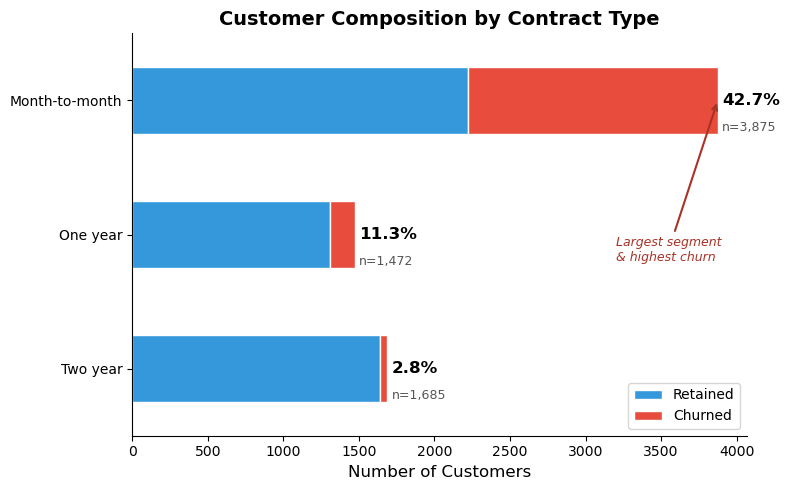

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

contract_order = ['Month-to-month', 'One year', 'Two year']
plot_data = df.groupby('contract')['churn'].value_counts().unstack().reindex(contract_order)

plot_data[['No', 'Yes']].plot(kind='barh', stacked=True, ax=ax,
                               color=['#3498db', '#e74c3c'], edgecolor='white')

ax.invert_yaxis()  # Month-to-month on top

# Add labels
for i, contract in enumerate(contract_order):
    total = plot_data.loc[contract].sum()
    churned = plot_data.loc[contract, 'Yes']
    rate = churned / total * 100
    ax.text(total + 30, i, f'{rate:.1f}%', va='center', fontsize=12, fontweight='bold')
    ax.text(total + 30, i + 0.2, f'n={total:,.0f}', va='center', fontsize=9, color='#555555')

# Highlight Month-to-month
ax.annotate('Largest segment\n& highest churn', xy=(3875, 0), xytext=(3200, 1.2),
            fontsize=9, color='#a93226', fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='#a93226', lw=1.5))

ax.set_xlabel('Number of Customers', fontsize=12)
ax.set_ylabel('')
ax.set_title('Customer Composition by Contract Type', fontsize=14, fontweight='bold')
ax.legend(['Retained', 'Churned'], loc='lower right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()